# **Configuración del ambiente**

En el proyecto usaremos 5 variables que serán manipuladas dentro de varias funciones, estas variables son conocidas como variables globales, y se definen aquí de la siguiente forma:

global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import yfinance as yf

In [3]:
from bs4 import BeautifulSoup

In [4]:
import requests
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError
from IPython.display import clear_output
import time
import datetime as dt

# Definición de variables globales

In [5]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

# Obtención de datos

**Obtener los datos históricos de Bitcoin**

In [6]:
def importar_base_bitcoin():
  global df_bitcoin
  msft = yf.Ticker("BTC-USD")
  df_bitcoin = msft.history(interval='5m', period='7d')
  return df_bitcoin

**Obtención de datos, Web Scraping**

In [7]:
def extraer_tendencias():
  global precio_actual, tendencia

  headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'}
  url = 'https://coinmarketcap.com/'

  name=[]
  precio_texto =[]
  tendencia = []

  try:
    response = requests.get(url, headers= headers)
    s = BeautifulSoup(response.content, features="lxml")

    names = s.findAll('div', {'class':['sc-c745a311-2 eqFvXC','sc-4984dd93-0 iqdbQL coin-item-symbol']})
    precio_text = s.findAll('div',{'class':['sc-bc83b59-0 iVdfNf', 'sc-bc83b59-0 iVdfNf fall','sc-bc83b59-0 iVdfNf rise']})


    for item in names:
      name.append(item.text.strip())


    for precio in precio_text:
      precio_texto.append(precio.text.replace("$", "").replace(",", ""))


    variacion_text = s.findAll('span', {'class': ['sc-97d6d2ca-0 cYiHal','sc-97d6d2ca-0 bQjSqS']})

    for var in variacion_text:
      if str (var.contents[0]).find('icon-Caret-up')>0:
        tendencia.append(1)
      else:
        tendencia.append(0)
    tendencia = tendencia[::3]


    datos = {
        'Precio_texto':precio_texto,
        'Tendencia':tendencia
    }

    dataset = pd.DataFrame(datos, index = name)
    dataset = dataset.loc[['BTC']]

    precio_actual = float(dataset.Precio_texto)
    tendencia = int(dataset.Tendencia)

    if tendencia ==1:
      tendencia ='alta'
    else:
      tendencia ='baja'
  except HTTPError as e:
    print(e.status, e.reason)
  except URLError as e:
    print(e.reason)

  return [precio_actual,tendencia ]

# Limpieza de datos

**Limpieza de datos**
Se crea una copia de la base df_bitcoin para  realizar la limpieza en esta nueva base(df_bitcoin_limpio), sin modificar la base original, el  contenido es:

Datetime: Es el índice del dataframe, y contiene la fecha y hora del intervalo seleccionado, no puede estar duplicado.

Open: Contiene el precio del Bitcoin al inicio del intervalo.

High: Contiene el precio más alto del Bitcoin durante el intervalo.

Low: Contiene el precio más bajo del Bitcoin durante el intervalo.

Close: Contiene el precio del Bitcoin al final del intervalo.

Volume: Contiene el total de transacciones hechas durante el intervalo.

Para la limpieza utilizaremos los atributos Datetime, Close y Volume.

en la base df_bitcoin_limpio, se identifican:
1. Duplicados en el índice y se trátan para quedar con sólo índices únicos.
2. Se buscan los valores nulos en la columna Close.
3. Se verifica que todos los registros de la base tengan un Volume de transacción mayor a 0, caso contrário, se  eliminan.
4. Se identifican y eliminan los outliers en el precio del Bitcoin, columna Close.Se utiliza un gráfico de boxplot para identificarlos.
5. Se filtra o selecciona únicamente los registros cuyo precio(Close) se encuentren entre el 1er cuartil(Q1) y el 3er cuartil(Q3) del boxplot.
6. Finalmente, calcula el precio promedio(Close) de esta selección y guárdala en la variable media_bitcoin.

In [8]:
def limpieza_datos():
  global df_bitcoin_limpio,media_bitcoin,df_bitcoin_Final

  df_bitcoin_limpio = df_bitcoin.copy()

  ''' se aplica directamente al índice del DataFrame df_bitcoin_limpio, el argumento keep='first'
  indica que se debe mantener la primera aparición de cada índice y eliminar las apariciones posteriores.
  Al utilizar este método en el índice, se actualizará el DataFrame df_bitcoin_limpio eliminando las filas duplicadas
  en función de los índices.'''

  df_bitcoin_limpio = df_bitcoin_limpio.drop_duplicates(keep='first' )

  # Eliminar filas con valores nulos en una columna específica

  df_bitcoin_limpio = df_bitcoin_limpio.dropna(subset=['Close'])

  # Verificar y eliminar las filas donde Volume es menor o igual a cero

  valores_menores_a_cero = (df_bitcoin_limpio['Volume'] < 0).sum()
  print(valores_menores_a_cero)
  df_bitcoin_limpio = df_bitcoin_limpio.query(f"{'Volume'} > 0").copy()

  # Identificar y eliminar outliers en la columna Close utilizando un boxplot

  columna = 'Close'
  plt.boxplot(df_bitcoin_limpio[columna])
  plt.xlabel(columna)
  plt.ylabel('Valor')
  plt.title('Boxplot de Precios de Bitcoin')
  plt.show()

  ''' se calculan los cuartiles y el rango intercuartílico (IQR). El cuartil 1 (Q1) representa el
  valor por debajo del cual se encuentra el 25% de los datos ordenados en forma ascendente.
  El cuartil 3 (Q3) representa el valor por debajo del cual se encuentra el 75% de los datos
  ordenados en forma ascendente. El rango intercuartílico (IQR) se calcula como la diferencia entre Q3 y Q1.'''

  Q1 = df_bitcoin_limpio['Volume'].quantile(0.25)
  Q3 = df_bitcoin_limpio['Volume'].quantile(0.75)
  IQR = Q3 - Q1

  ''' Se crea un nuevo DataFrame  que contiene solo las filas  que cumplen con  que el valor de la columna 'Volume'
  esté dentro de un rango definido por Q1 - 1.5 * IQR en el extremo inferior y Q3 + 1.5 * IQR en el extremo superior.'''

  df_bitcoin_Final = df_bitcoin_limpio[(df_bitcoin_limpio['Volume'] >= Q1 - 1 * IQR) & (df_bitcoin_limpio['Volume'] <= Q3 + 1 * IQR)]

  #Calcular el precio promedio (Close)

  media_bitcoin = round((df_bitcoin_Final['Close'].mean()),2)


# Tomar decisiones

**Tomar decisiones**

se crea una funcion tomar_decisiones(),  se rellena la variable algoritmo_decision con el valor resultante del siguiente criterio de decisión:
Si el precio actual es mayor/igual que el precio promedio y la tendencia es de baja, entonces guarda el valor ‘Vender’.
Si el precio actual es menor que el precio promedio y la tendencia es de alta, entonces guarda el valor ‘Comprar’.
Si ninguna de las 2 condiciones anteriores se cumple, entonces guarda el valor ''.

In [9]:
def tomar_decisiones():
  global algoritmo_decision

  if ((precio_actual >= media_bitcoin) &(tendencia == 'baja')):
     algoritmo_decision = 'Vender'
  elif ((precio_actual < media_bitcoin) &(tendencia == 'alta')):
     algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = 'Esperar'

  return  algoritmo_decision + ' precio actual: ' + str(precio_actual) + ' tendencia: ' + tendencia + ' precio promedio: ' + str(media_bitcoin)


# Visualización

In [10]:
def visualizacion():

  df_bitcoin['Promedio']= media_bitcoin

  # Configurar el tamaño predeterminado de las figuras

  plt.rc('figure', figsize=(16, 5))

  # Graficar la línea con los datos del índice y la columna 'Close'
  plt.plot(df_bitcoin.index, df_bitcoin['Close'], label='Close')

  # Graficar la línea con los datos del índice y la columna 'Promedio'
  plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], label='Promedio')
  # Anotar un mensaje en el gráfico
  decision = tomar_decisiones()
  plt.annotate(decision, xy=(df_bitcoin.index[10], df_bitcoin['Close'].iloc[10]), xytext=(df_bitcoin.index[800], df_bitcoin['Close'].iloc[800]))

  # Agregar título y etiquetas de los ejes
  plt.title('Gráfico de Bitcoin')
  plt.xlabel('Fecha')
  plt.ylabel('Valor')

  # Mostrar la leyenda

  plt.legend()

  # Mostrar el gráfico
  plt.show()


# Automatización

finalmente construiremos un loop infinito para ejecutar permanentemente y en intervalos de 5 minutos, las funciones  construídas en los pasos 2 al 5

El resultado de este código será un gráfico mostrando el histórico de precios del Bitcoin y la decisión del algoritmo en tiempo real,
basado en datos normalizados y limpios, que se actualizarán cada 5 minutos.

este codigo es una demonstración de un proyecto real, donde se puede ver el poder de los datos para la toma de decisiones y la importancia
que tiene el tratamiento de los datos para evitar tomar decisiones equivocadas

0


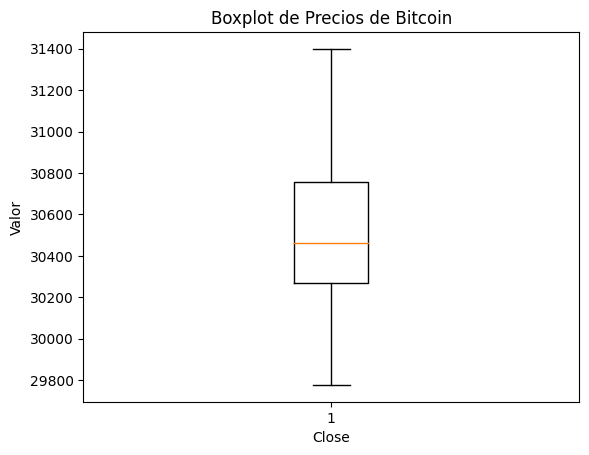

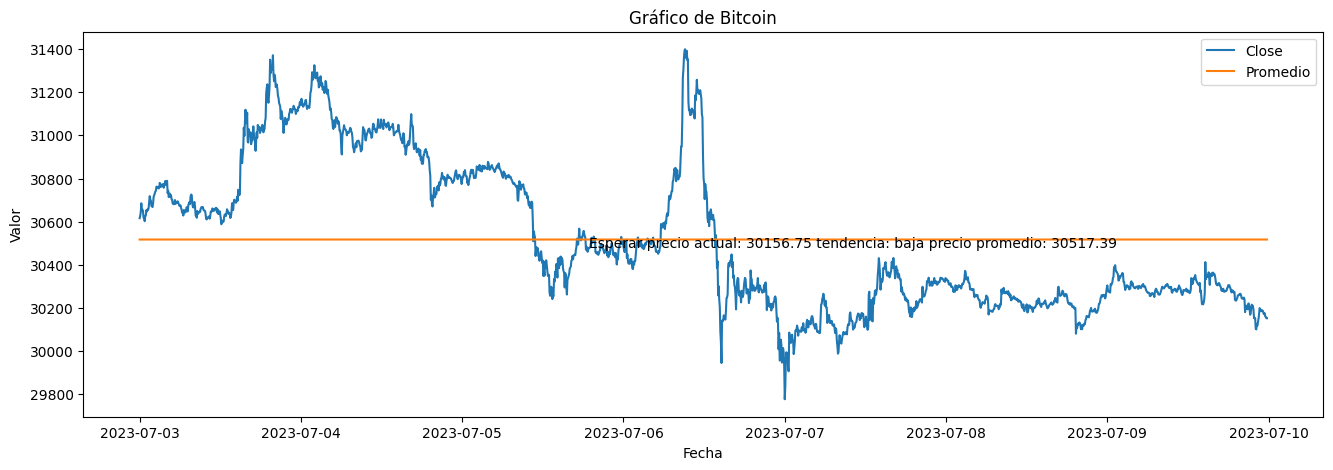

KeyboardInterrupt: ignored

In [11]:
from IPython.display import clear_output
import time
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)